In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from collections import defaultdict

os.makedirs('./plots', exist_ok=True)
sns.set()

# Zadanie 1-1

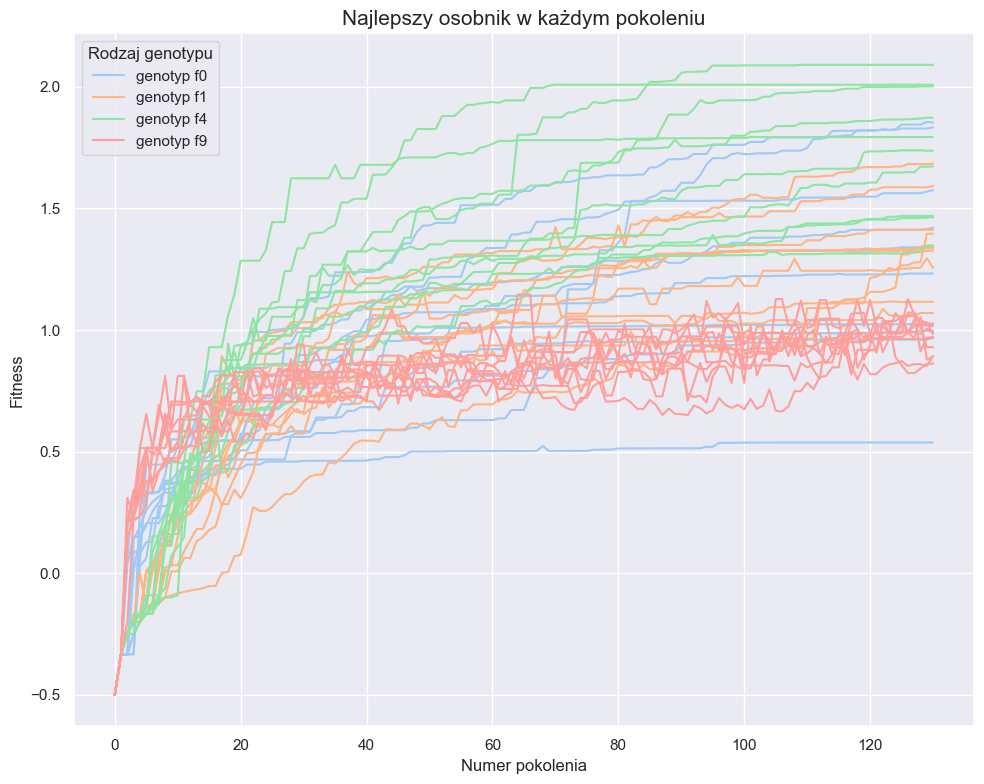

In [54]:
G_VALUES = ["0", "1", "4", "9"]
palette = sns.color_palette("pastel", len(G_VALUES))
color_map = dict(zip(G_VALUES, palette)) 
plt.figure(figsize=(10, 8))

for g_value in G_VALUES:
    for i in range(1, 11):
        df = pd.read_csv(f"../framspy/lab4/f{g_value}/Deap/{i}.csv", usecols=['gen', 'max'])
        sns.lineplot(df, x='gen', y='max', color=color_map[g_value], label=f"genotyp f{g_value}" if i == 1 else "")

plt.title("Najlepszy osobnik w każdym pokoleniu", fontsize=15)
plt.ylabel("Fitness")
plt.xlabel("Numer pokolenia")

plt.legend(title="Rodzaj genotypu")
plt.tight_layout()
plt.savefig('plots/1-przebiegi.png')
plt.show()

# Zadanie 1-2

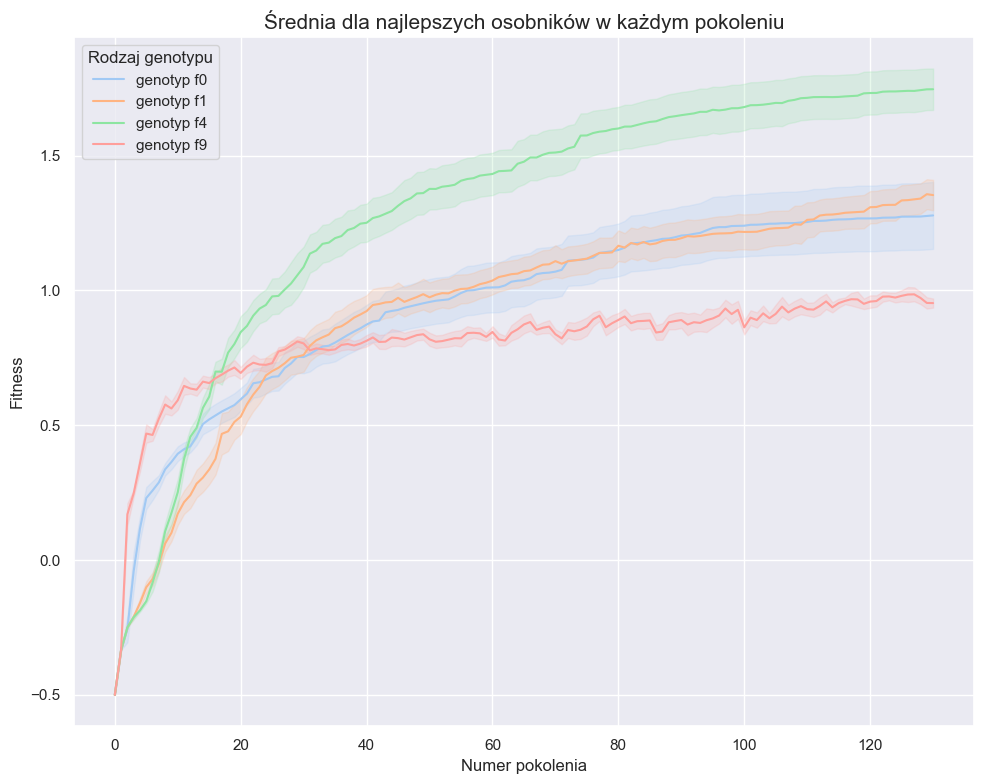

In [55]:
plt.figure(figsize=(10, 8))
for g_value in G_VALUES:
    df = pd.DataFrame()
    for i in range(1, 11):
        df_temp = pd.read_csv(f"../framspy/lab4/f{g_value}/Deap/{i}.csv", usecols=['gen', 'max'])
        df = pd.concat([df, df_temp])
    sns.lineplot(df, x='gen', y='max', color=color_map[g_value], label=f"genotyp f{g_value}", errorbar=("sd", 0.3))   

plt.title("Średnia dla najlepszych osobników w każdym pokoleniu", fontsize=15)
plt.ylabel("Fitness")
plt.xlabel("Numer pokolenia")

plt.legend(title="Rodzaj genotypu")
plt.tight_layout()
plt.savefig('plots/1-przebiegi-agregacja.png')
plt.show()

# Zadanie 1-3

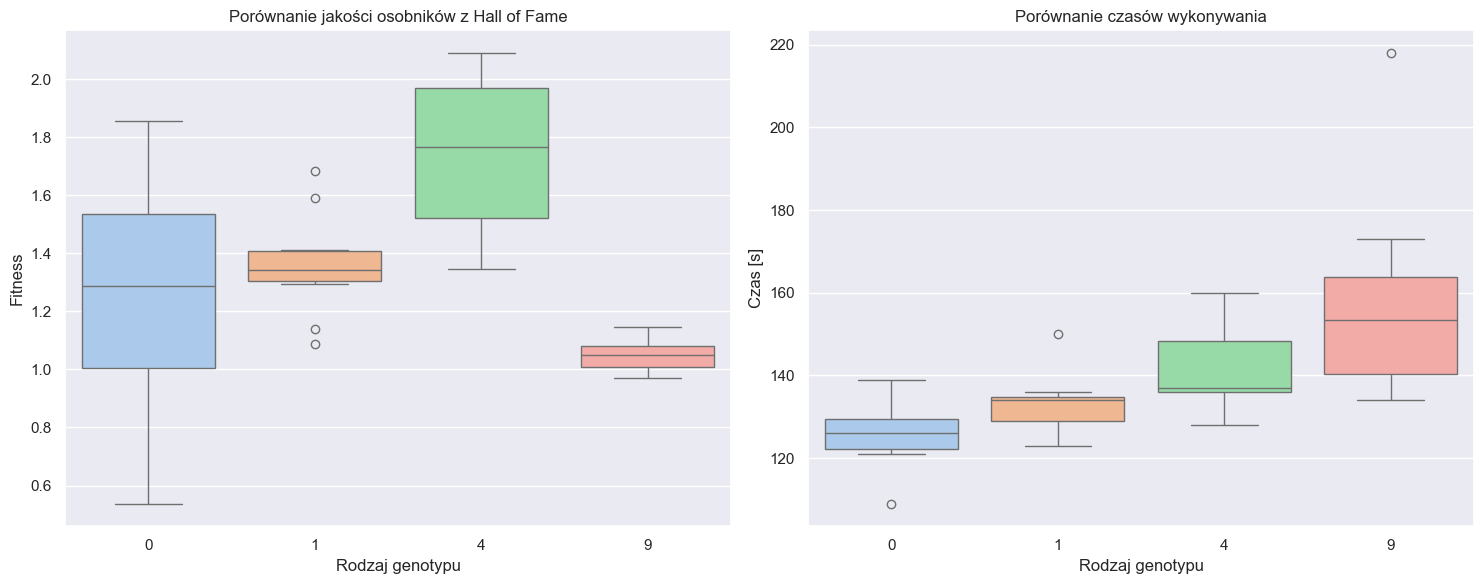

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes = axes.flatten()

# FITNESS
data = {g_value: [] for g_value in G_VALUES}
for g_value in G_VALUES:
    for i in range(1, 11):
        with open(f"../framspy/lab4/f{g_value}/HoF/{i}.gen") as file:
            for line in file:
                if line.startswith("vertpos"):
                    value = float(line.split(':')[1])
                    data[g_value].append(value)
        
df = pd.DataFrame(data)
sns.boxplot(df, palette='pastel', ax=axes[0])
axes[0].set_title("Porównanie jakości osobników z Hall of Fame")
axes[0].set_xlabel("Rodzaj genotypu")
axes[0].set_ylabel("Fitness")

# EXECUTION TIME
data = {g_value: [] for g_value in G_VALUES}
for g_value in G_VALUES:
    df = pd.read_csv(f"../framspy/lab4/f{g_value}/times.txt")
    data[g_value] = df['time'].to_list()
    
df = pd.DataFrame(data)
sns.boxplot(df, palette='pastel', ax=axes[1])
axes[1].set_title("Porównanie czasów wykonywania")
axes[1].set_xlabel("Rodzaj genotypu")
axes[1].set_ylabel("Czas [s]")

plt.tight_layout()
plt.savefig('plots/1-boxplot.png')
plt.show()

# Zadanie 1-mutacje

- Ile procent mutacji poprawiło wynik osobnika oryginalnego?
- Ile procent mutacji poprawiło wynik osobnika oryginalnego dla fitness mniejszego niż max(fitness)/2 ?
- Ile procent mutacji poprawiło wynik osobnika oryginalnego dla fitness większego niż max(fitness)/2 ?

In [59]:
data = defaultdict(list)
for g_value in G_VALUES:
    
    df = pd.read_csv(f"../framspy/lab4/f{g_value}/mutations.csv")
    df_01 = (df.drop(columns='fitness_original').gt(df['fitness_original'], axis=0)).astype(int)
    data[g_value].append((df_01.values.sum() / df_01.size) * 100)
    
    df = pd.read_csv(f"../framspy/lab4/f{g_value}/mutations.csv")
    df = df.loc[:len(df)//2, :]
    df_01 = (df.drop(columns='fitness_original').gt(df['fitness_original'], axis=0)).astype(int)
    data[g_value].append((df_01.values.sum() / df_01.size) * 100)

    df = pd.read_csv(f"../framspy/lab4/f{g_value}/mutations.csv")
    df = df.loc[len(df)//2:, :]
    df_01 = (df.drop(columns='fitness_original').gt(df['fitness_original'], axis=0)).astype(int)
    data[g_value].append((df_01.values.sum() / df_01.size) * 100)

pd.DataFrame(data, index=['all', 'lower', 'higher'])

0          1          4          9
all     11.157685  14.930140  16.127745  22.554890
lower   15.059761  22.051793  21.454183  37.569721
higher   7.250996   7.808765  10.737052   7.589641

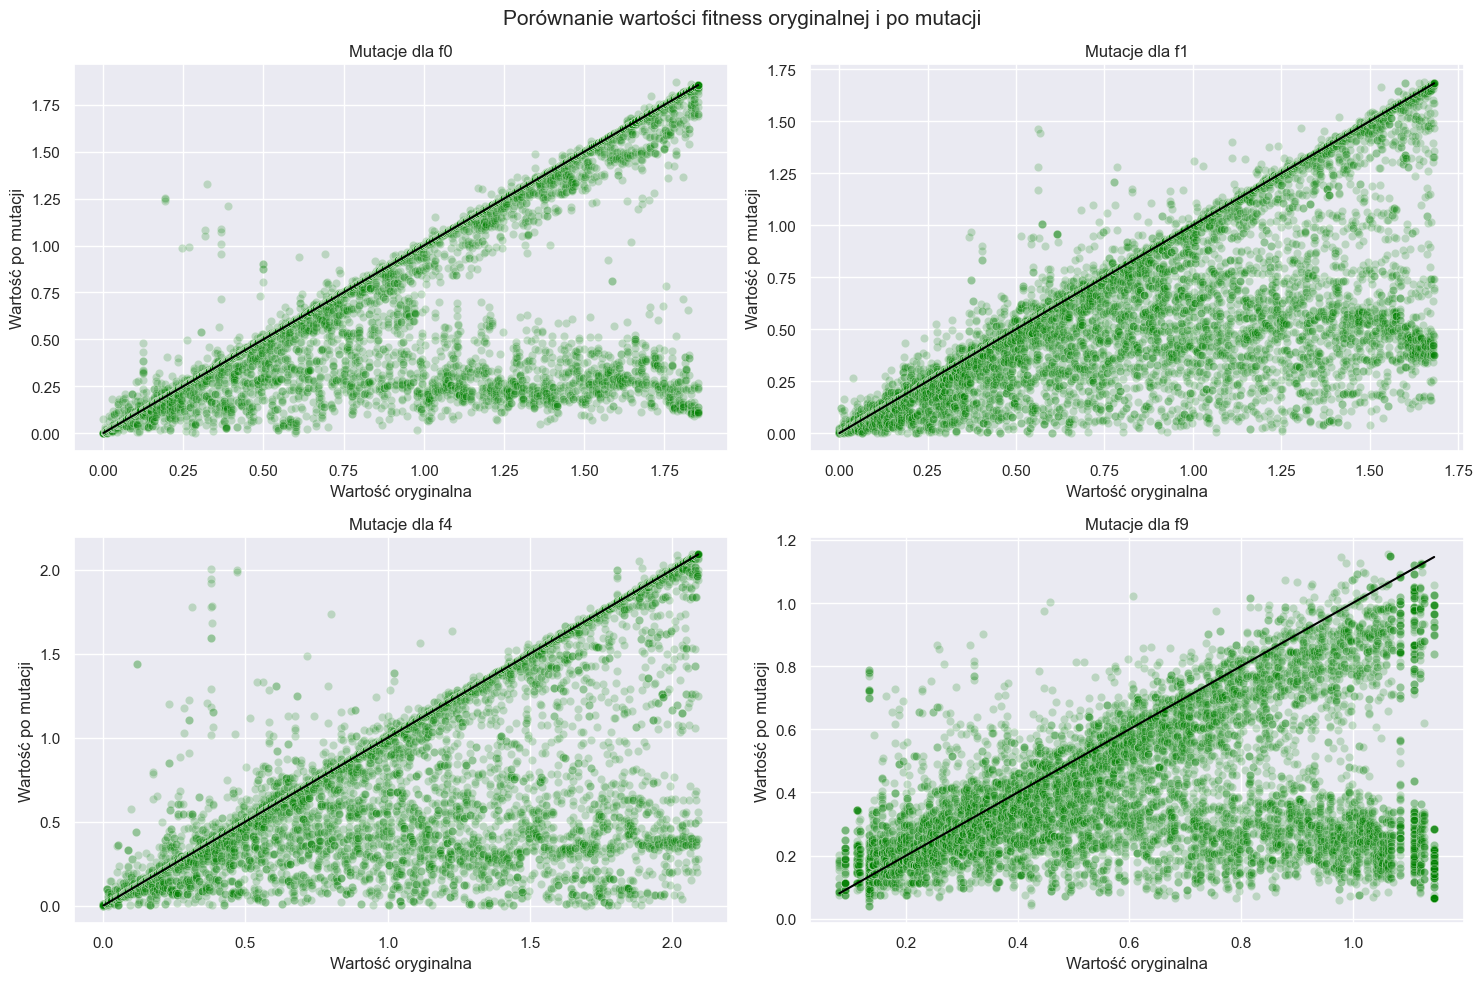

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, g_value in enumerate(G_VALUES):
    df = pd.read_csv(f"../framspy/lab4/f{g_value}/mutations.csv")
    for idx in df.index:
        df_temp = pd.DataFrame(df.loc[idx, df.columns != 'fitness_original']).rename(columns=lambda x: 'fitness_mutation')
        df_temp = df_temp[df_temp > 0]
        df_temp['fitness_original'] = [df.loc[idx, 'fitness_original']]*len(df_temp)
        sns.scatterplot(df_temp, x='fitness_original', y='fitness_mutation', alpha=0.2, c='green', ax=axes[i])

    sns.lineplot(df, x='fitness_original', y='fitness_original', c='black', ax=axes[i])
    axes[i].set_title(f"Mutacje dla f{g_value}")
    axes[i].set_xlabel("Wartość oryginalna")
    axes[i].set_ylabel("Wartość po mutacji")

plt.suptitle("Porównanie wartości fitness oryginalnej i po mutacji", fontsize=15)
plt.tight_layout()
plt.savefig('plots/1-mutacje.png')
plt.show()

# Zadanie 2 - krzyżowanie

Ile procent dzieci poprawiło obu swoich rodziców?

In [93]:
data = {}
for g_value in G_VALUES:
    df = pd.read_csv(f"../framspy/lab4/f{g_value}/crossovers.csv")
    df['greater'] = (df['fitness_child'] > df['fitness_parent_1']) & (df['fitness_child'] > df['fitness_parent_2'])
    data[g_value] = df['greater'].sum() / len(df) * 100

pd.Series(data)

0    0.758590
1    1.714741
4    2.717131
9    6.955217
dtype: float64

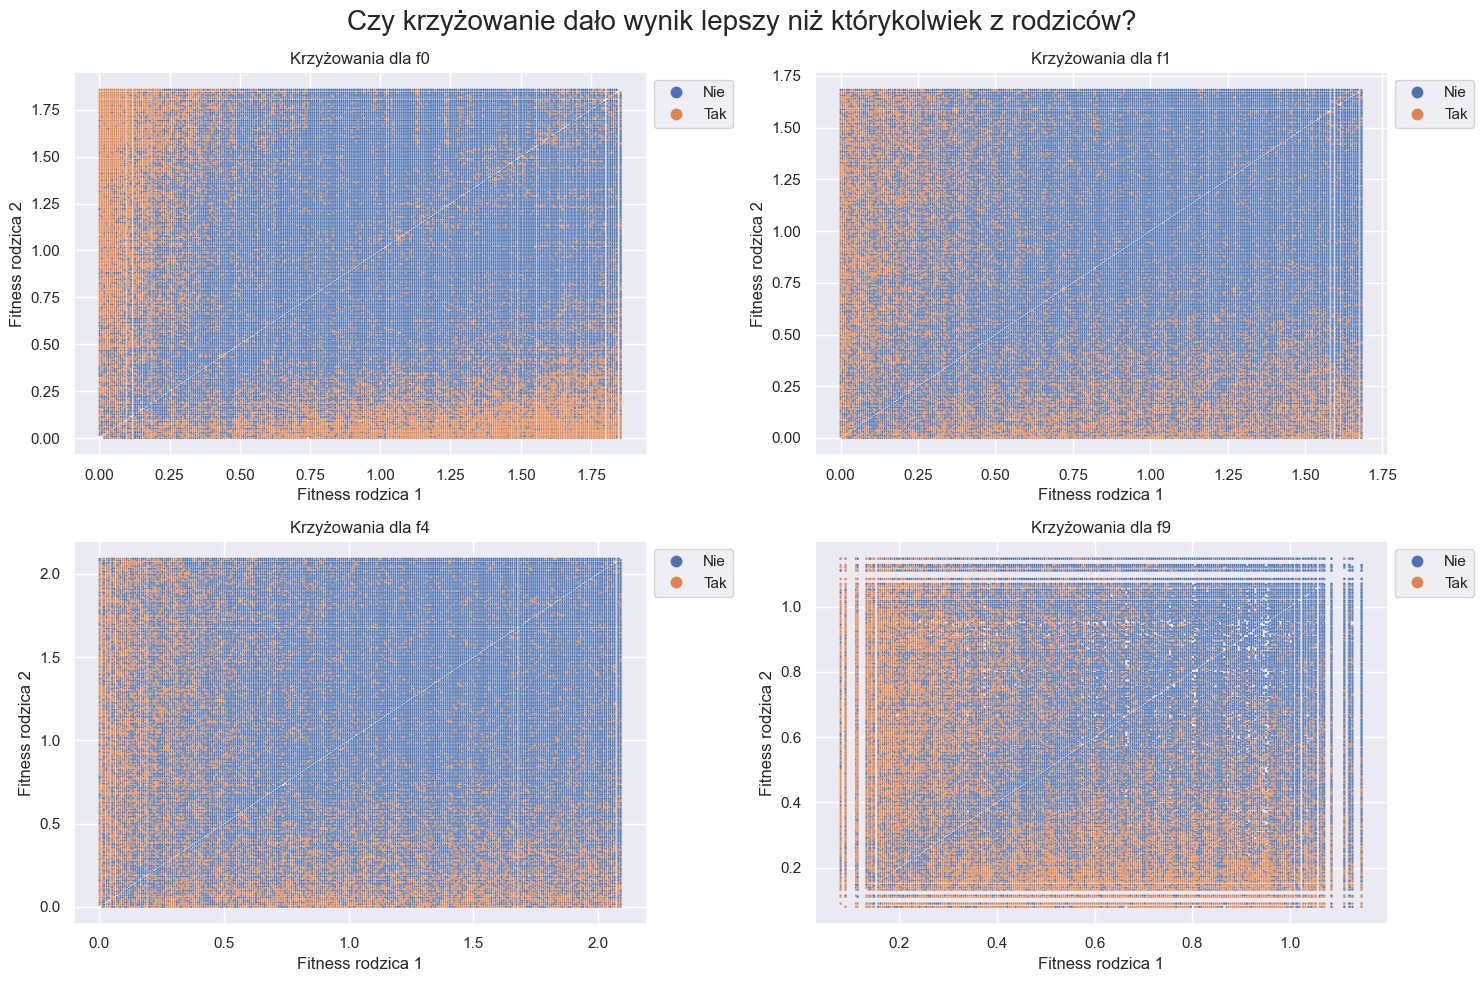

In [89]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, g_value in enumerate(G_VALUES):
    df = pd.read_csv(f"../framspy/lab4/f{g_value}/crossovers.csv")
    df = df[df['fitness_child'] != -999999.0]
    df['greater'] = (df['fitness_child'] > df['fitness_parent_1']) | (df['fitness_child'] > df['fitness_parent_2'])
    sns.scatterplot(df, x='fitness_parent_1', y='fitness_parent_2', hue='greater', ax=axes[i], s=3)
    axes[i].set_title(f"Krzyżowania dla f{g_value}")
    axes[i].set_xlabel("Fitness rodzica 1")
    axes[i].set_ylabel("Fitness rodzica 2")
    handles, _ = axes[i].get_legend_handles_labels()
    axes[i].legend(handles=handles, loc='upper left', bbox_to_anchor=(1, 1), markerscale=5, labels=["Nie", "Tak"])

plt.suptitle("Czy krzyżowanie dało wynik lepszy niż którykolwiek z rodziców?", fontsize=20)
plt.tight_layout()
plt.savefig('plots/2-krzyzowania-lepszy-or.png')
plt.show()

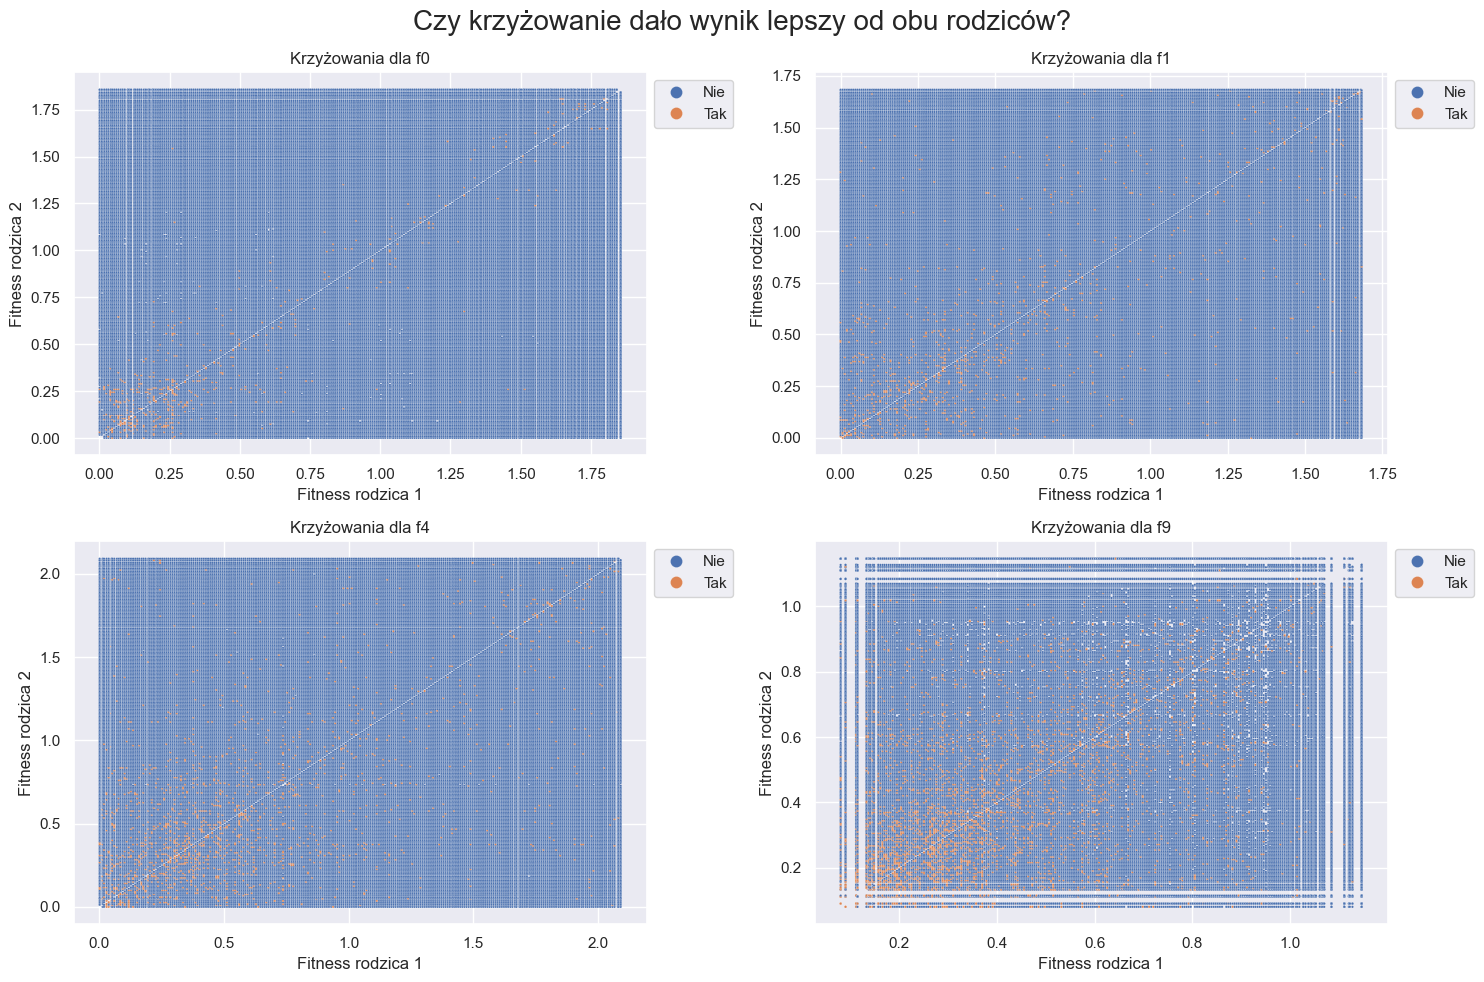

In [90]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, g_value in enumerate(G_VALUES):
    df = pd.read_csv(f"../framspy/lab4/f{g_value}/crossovers.csv")
    df = df[df['fitness_child'] != -999999.0]
    df['greater'] = (df['fitness_child'] > df['fitness_parent_1']) & (df['fitness_child'] > df['fitness_parent_2'])
    sns.scatterplot(df, x='fitness_parent_1', y='fitness_parent_2', hue='greater', ax=axes[i], s=3)
    axes[i].set_title(f"Krzyżowania dla f{g_value}")
    axes[i].set_xlabel("Fitness rodzica 1")
    axes[i].set_ylabel("Fitness rodzica 2")
    handles, _ = axes[i].get_legend_handles_labels()
    axes[i].legend(handles=handles, loc='upper left', bbox_to_anchor=(1, 1), markerscale=5, labels=["Nie", "Tak"])

plt.suptitle("Czy krzyżowanie dało wynik lepszy od obu rodziców?", fontsize=20)
plt.tight_layout()
plt.savefig('plots/2-krzyzowania-lepszy-and.png')
plt.show()

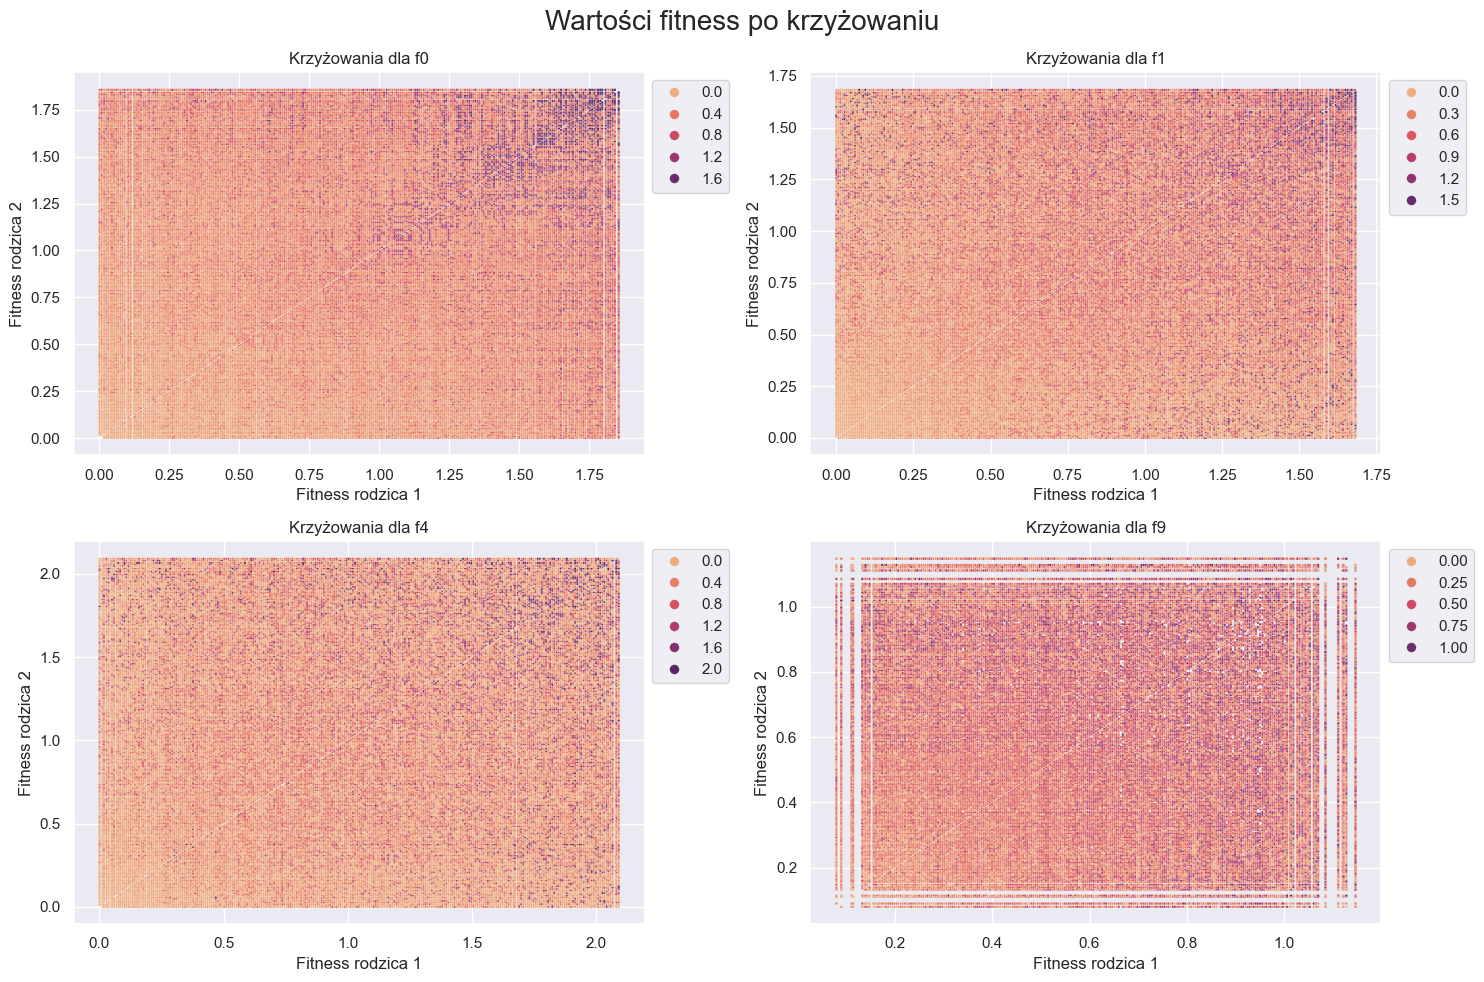

In [88]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, g_value in enumerate(G_VALUES):
    df = pd.read_csv(f"../framspy/lab4/f{g_value}/crossovers.csv")
    df = df[df['fitness_child'] != -999999.0]
    sns.scatterplot(df, x='fitness_parent_1', y='fitness_parent_2', hue='fitness_child', palette='flare', ax=axes[i], s=3)
    axes[i].set_title(f"Krzyżowania dla f{g_value}")
    axes[i].set_xlabel("Fitness rodzica 1")
    axes[i].set_ylabel("Fitness rodzica 2")
    axes[i].legend(loc='upper left', bbox_to_anchor=(1, 1), markerscale=4)

plt.suptitle("Wartości fitness po krzyżowaniu", fontsize=20)
plt.tight_layout()
plt.savefig('plots/2-krzyzowania.png')
plt.show()

# Zadanie 3 - random walk

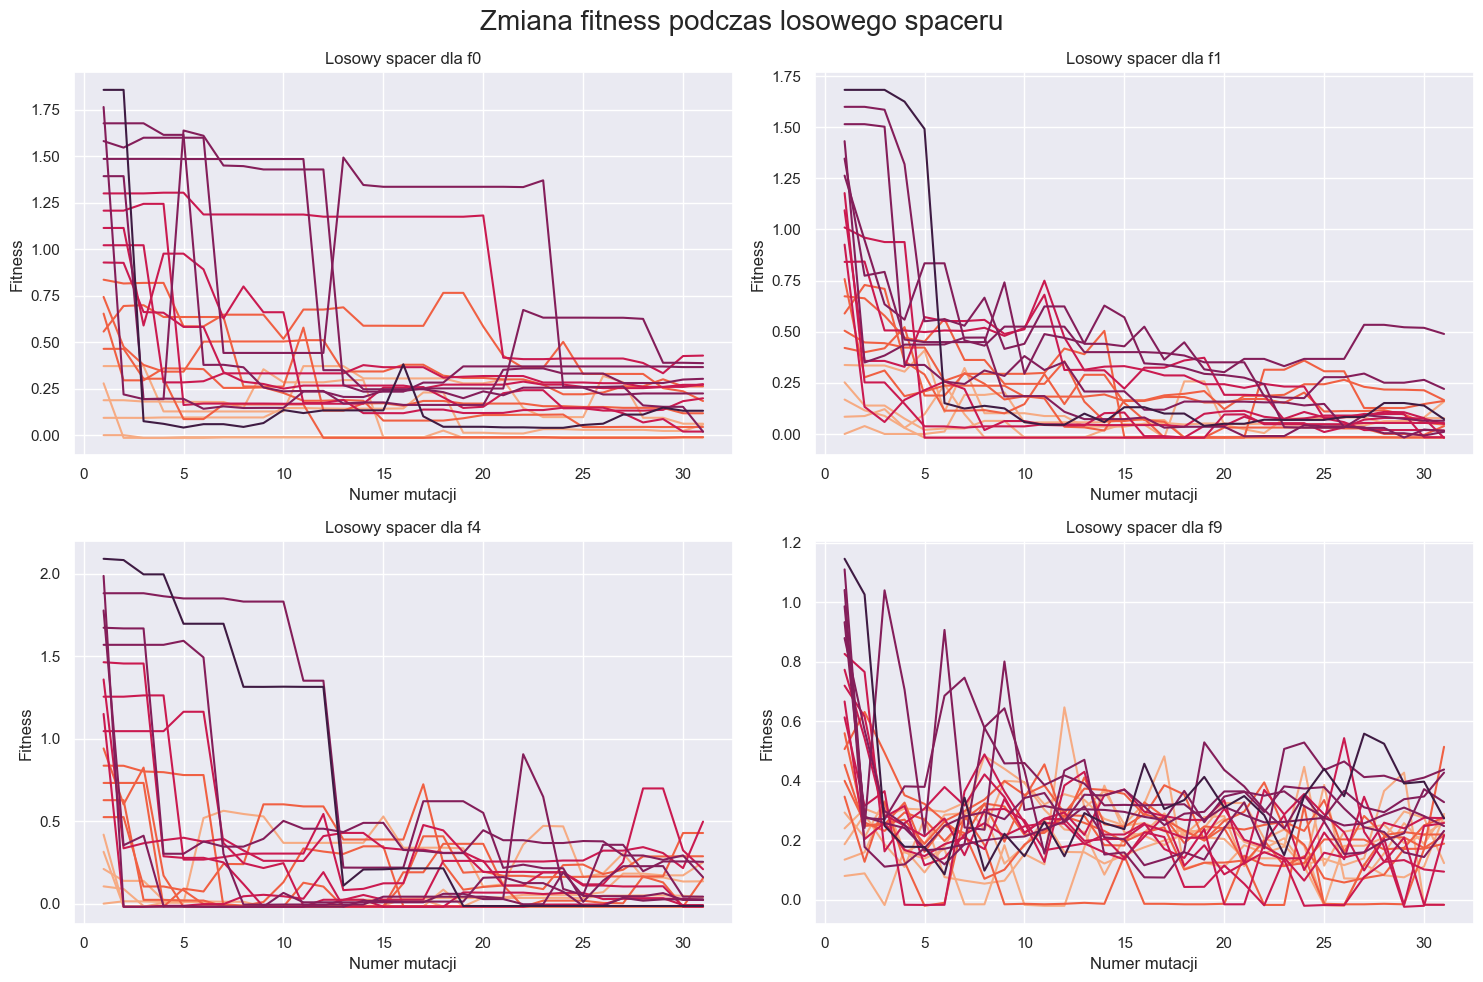

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()


for i, g_value in enumerate(G_VALUES):
    df = pd.read_csv(f"../framspy/lab4/f{g_value}/random-walk.csv")
    
    palette = sns.color_palette("rocket_r", len(df)//5+1)
    color_map = dict(zip(range(0, len(df)//5+1), palette))     
    
    for idx in df.index:
        df_t = df.loc[idx, :] 
        df_t.index = range(1, len(df_t)+1)
        sns.lineplot(df_t, ax=axes[i], color=color_map[idx//5])
                
        axes[i].set_title(f"Losowy spacer dla f{g_value}")
    axes[i].set_xlabel("Numer mutacji")
    axes[i].set_ylabel("Fitness")

plt.suptitle("Zmiana fitness podczas losowego spaceru", fontsize=20)
plt.tight_layout()
plt.savefig('plots/3-spacer.png')
plt.show()